In [2]:
# Load in some data!
library(readr)
beer=read_csv("../data/data.csv")

Parsed with column specification:
cols(
  ID = col_integer(),
  Size = col_double(),
  OG = col_double(),
  FG = col_double(),
  IBU = col_double(),
  Color = col_double(),
  BoilSize = col_double(),
  BoilTime = col_integer(),
  BoilGravity = col_double(),
  Efficiency = col_double(),
  MashThickness = col_double(),
  ABV = col_double()
)


# Initial Analysis of Data

In [3]:
# R doesn't have printf, so let's add it:
printf = function(...) invisible(print(sprintf(...)))

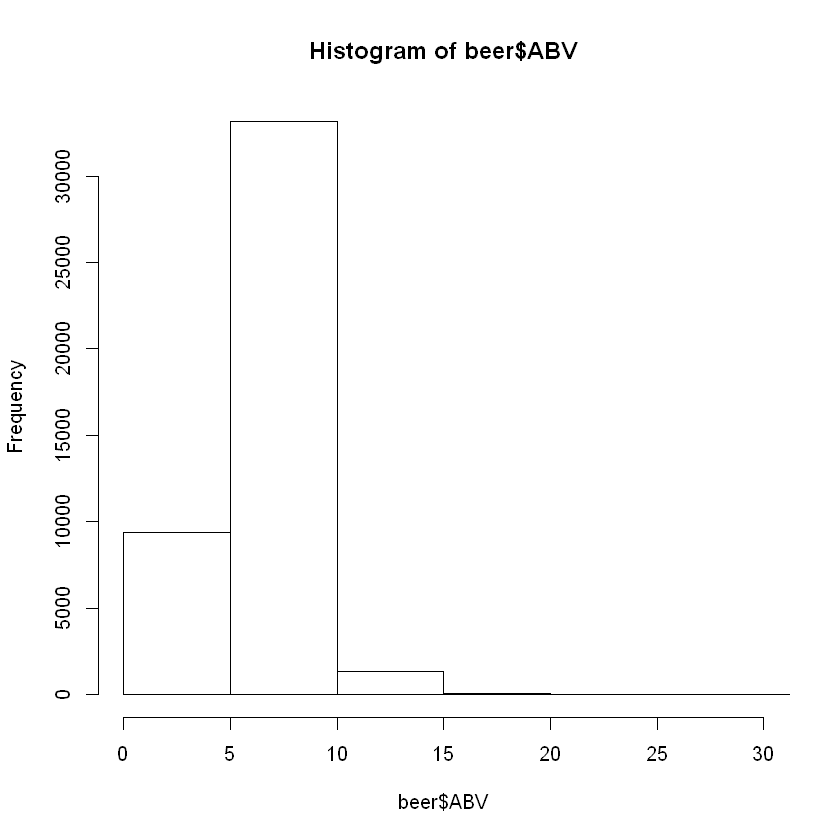

In [4]:
hist(beer$ABV, xlim=c(0,30))

Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'PerformanceAnalytics'

The following object is masked from 'package:graphics':

    legend



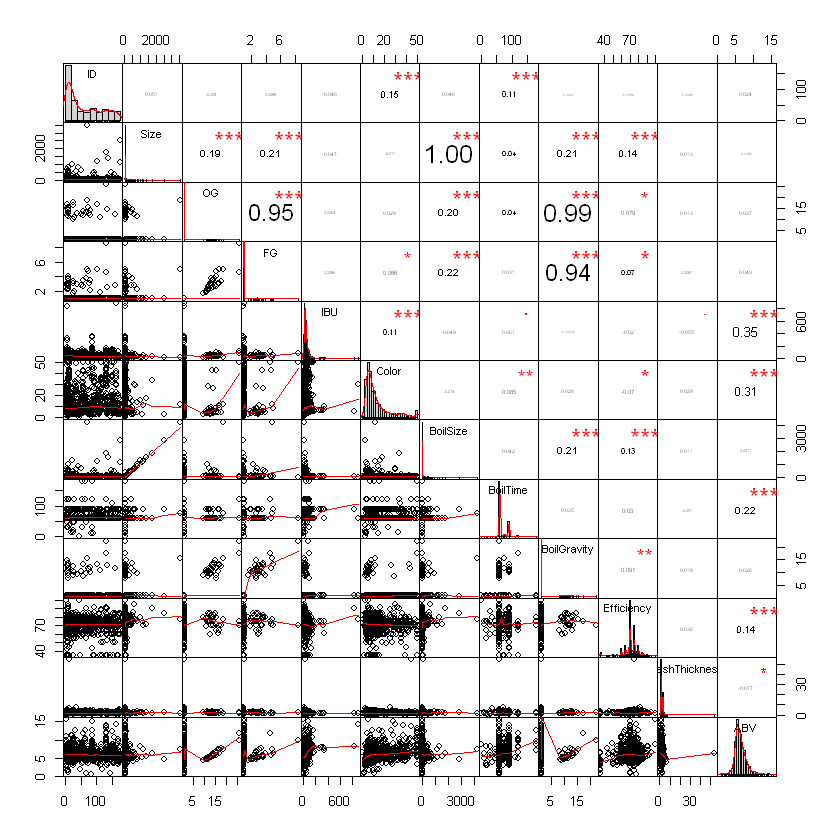

In [5]:
library(PerformanceAnalytics)
beer.subsample = beer[sample(1:nrow(beer),1000),]
chart.Correlation(beer.subsample)

[1] 7096

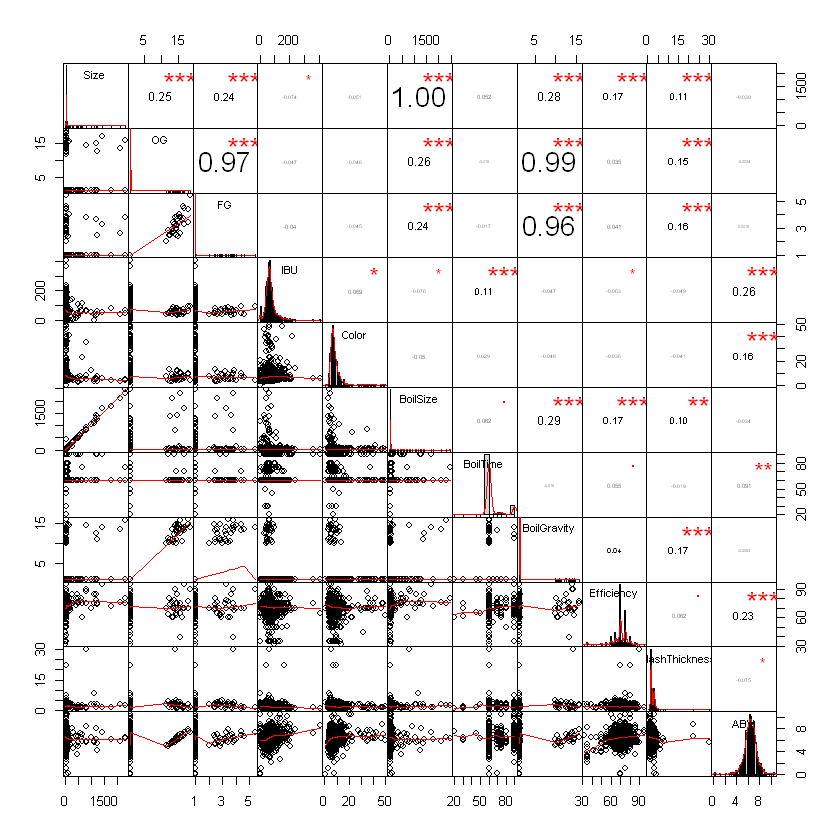

In [6]:
# We aren't seeing any good correlations, so let's take a look at just one style.
# Let's only look at American Brown Ale
beer.brownAle = beer[beer$ID == 7,]
nrow(beer.brownAle)
beer.brownAle.subsample = beer.brownAle[sample(1:nrow(beer.brownAle), 1000),]
# We'll drop beerID because we know it's all the same style
chart.Correlation(beer.brownAle.subsample[,2:12])

We still see those strange lines close to 0. If we look closer, we notice that the specific gravity measurement for this is very high.

Maple syrup, for comparison, has a SG of 1.37, but some of our sampled data have SG in the teens. 

This might indicate a data-quality issue; these are user-reported after all. For now, let's drop them and look at the data as a whole once again. 

[1] "Number of rows dropped: 1572"
[1] "Number of rows remaining: 42384"


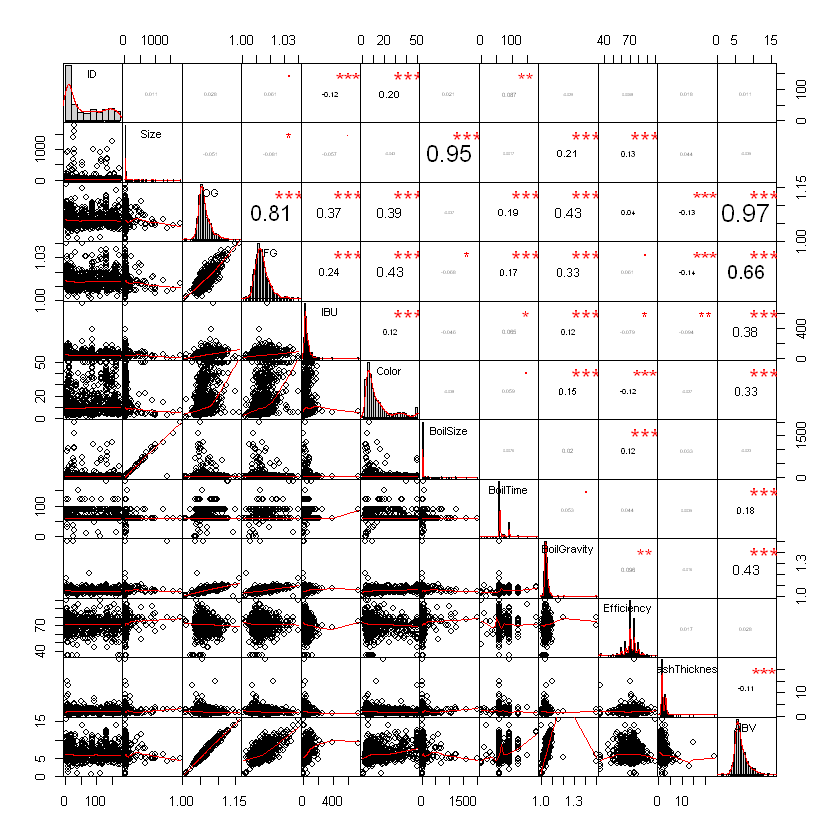

In [7]:
# Let's normal-gravity beers
beer.normGrav = beer[beer$OG < 3,]
beer.normGrav.subsample = beer.normGrav[sample(1:nrow(beer.normGrav), 1000),]
printf("Number of rows dropped: %i", nrow(beer) - nrow(beer.normGrav))
printf("Number of rows remaining: %i", nrow(beer.normGrav))
chart.Correlation(beer.normGrav.subsample)

Already, we see some very good correlation with the specific gravity of the original wort, specific gravity during boiling, and to a lesser extent the bitterness of the beer and final specific gravity. This makes sense, because the more sugar we add to the beer, the higher the specific gravity. With more sugar, the yeast have more food, and with some variance due to the strain of the yeast, will produce more alcohol.

# Ordinary Least Squares Regression

In [8]:
library(caret)

Loading required package: lattice
Loading required package: ggplot2


In [9]:
# For now, let's just look at the subsample we took
k10_cv = trainControl(method="cv", number=10)
beer.normGrav.subsample.ols = train(ABV~., data=beer.normGrav.subsample, trControl = k10_cv, method="lm")
print(beer.normGrav.subsample.ols)
summary(beer.normGrav.subsample.ols)

Linear Regression 

1000 samples
  11 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 899, 900, 900, 900, 900, 900, ... 
Resampling results:

  RMSE        Rsquared   MAE       
  0.07101821  0.9981987  0.04748316

Tuning parameter 'intercept' was held constant at a value of TRUE



Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.14207 -0.04054 -0.00348  0.03431  0.88434 

Coefficients:
                Estimate Std. Error  t value Pr(>|t|)    
(Intercept)   -5.193e-01  6.228e-01   -0.834  0.40460    
ID            -3.272e-05  4.021e-05   -0.814  0.41597    
Size          -5.367e-05  6.779e-05   -0.792  0.42873    
OG             1.311e+02  2.586e-01  507.042  < 2e-16 ***
FG            -1.308e+02  7.801e-01 -167.667  < 2e-16 ***
IBU           -2.512e-05  6.227e-05   -0.403  0.68675    
Color         -1.896e-04  2.145e-04   -0.884  0.37699    
BoilSize       3.723e-05  6.340e-05    0.587  0.55720    
BoilTime       4.182e-04  1.486e-04    2.815  0.00497 ** 
BoilGravity    1.854e-01  1.345e-01    1.378  0.16838    
Efficiency    -4.552e-05  2.967e-04   -0.153  0.87809    
MashThickness -2.136e-03  1.758e-03   -1.215  0.22460    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual stan

# LASSO

In [10]:
library(glmnet)
library(plotmo)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: plotrix
Loading required package: TeachingDemos


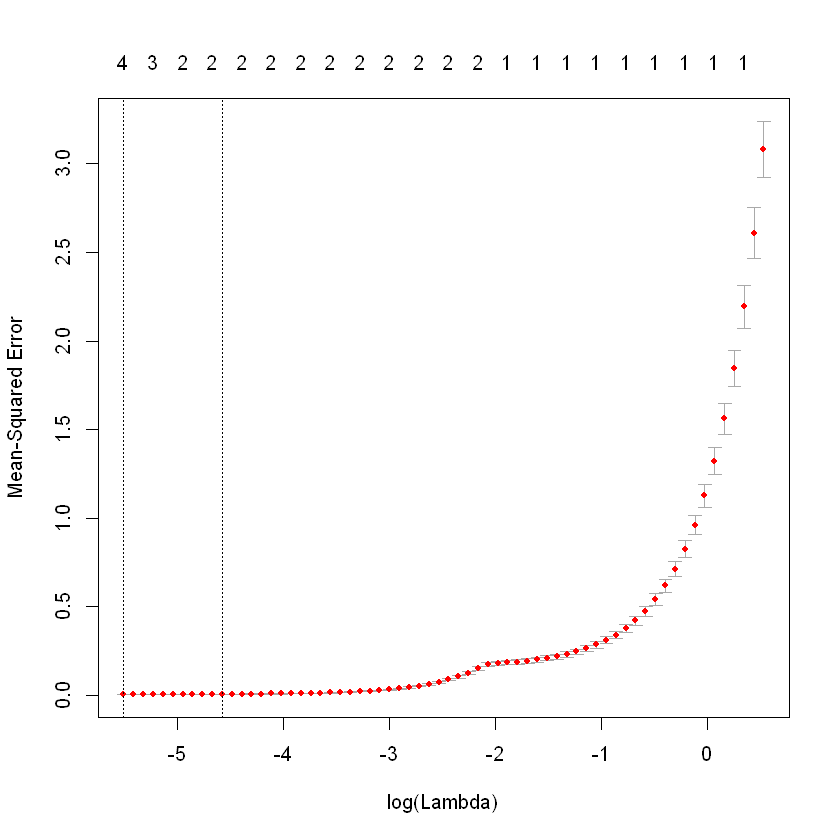

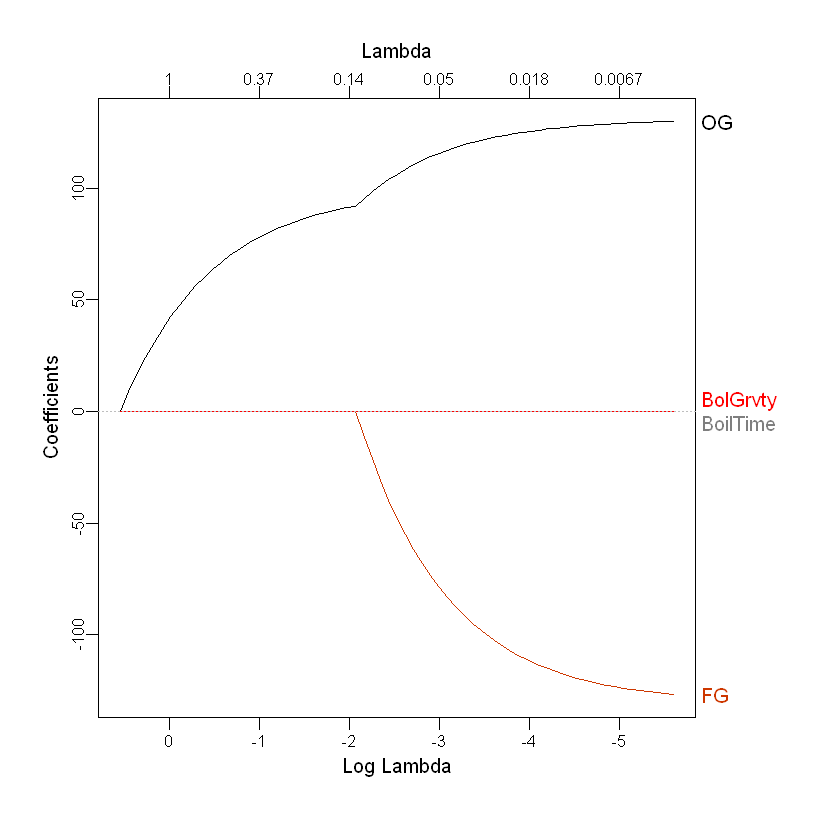

In [11]:
plot(cv.glmnet(x = as.matrix(beer.normGrav.subsample[1:11]), y = as.matrix(beer.normGrav.subsample[12]), alpha=1))
plot_glmnet(glmnet(x = as.matrix(beer.normGrav.subsample[1:11]), y=as.matrix(beer.normGrav.subsample[12]), alpha=1))

In [12]:
beer.normGrav.subsample.ols2 = train(ABV~OG + FG, data=beer.normGrav.subsample, trControl = k10_cv, method="lm")
print(beer.normGrav.subsample.ols2)
summary(beer.normGrav.subsample.ols2)

Linear Regression 

1000 samples
   2 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 900, 900, 900, 900, 900, 899, ... 
Resampling results:

  RMSE        Rsquared   MAE       
  0.06906927  0.9982645  0.04658056

Tuning parameter 'intercept' was held constant at a value of TRUE



Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13164 -0.04166 -0.00424  0.03368  0.90042 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)   -0.4092     0.5826   -0.702    0.483    
OG           131.2743     0.2247  584.295   <2e-16 ***
FG          -130.8688     0.7495 -174.599   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.07108 on 997 degrees of freedom
Multiple R-squared:  0.9984,	Adjusted R-squared:  0.9984 
F-statistic: 3.056e+05 on 2 and 997 DF,  p-value: < 2.2e-16


In [13]:
# ABV = -0.3285 + 131.4502 * Original_Specific_Gravity - 131.1261 * Final_Specific_Gravity
# But can we do better by only looking at OG? It's correlated with FG after all.
beer.normGrav.subsample.ols1 = train(ABV~OG, data=beer.normGrav.subsample, trControl = k10_cv, method="lm")
print(beer.normGrav.subsample.ols1)
summary(beer.normGrav.subsample.ols1)

Linear Regression 

1000 samples
   1 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 900, 900, 900, 899, 901, 900, ... 
Resampling results:

  RMSE       Rsquared   MAE     
  0.3993259  0.9486837  0.305193

Tuning parameter 'intercept' was held constant at a value of TRUE



Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.35211 -0.21934 -0.02922  0.26033  1.36533 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -99.2174     0.7771  -127.7   <2e-16 ***
OG           99.3235     0.7321   135.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3992 on 998 degrees of freedom
Multiple R-squared:  0.9486,	Adjusted R-squared:  0.9485 
F-statistic: 1.841e+04 on 1 and 998 DF,  p-value: < 2.2e-16


# Linear Smoothers

## K-nearest Neighbors

k-Nearest Neighbors 

1000 samples
  11 predictor

Pre-processing: centered (11), scaled (11) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 900, 900, 900, 901, 900, 900, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  0.8611045  0.7602591  0.6451613
   2  0.7835172  0.8040702  0.5708588
   3  0.7559438  0.8237190  0.5405451
   4  0.7625411  0.8270538  0.5395887
   5  0.7637606  0.8310097  0.5451126
   6  0.7876092  0.8209524  0.5557277
   7  0.7965611  0.8195928  0.5600870
   8  0.8067861  0.8184526  0.5708804
   9  0.8087960  0.8228750  0.5749413
  10  0.8103057  0.8272236  0.5749070
  11  0.8107431  0.8316208  0.5751060
  12  0.8145115  0.8323955  0.5775940
  13  0.8187682  0.8309862  0.5816651
  14  0.8250613  0.8307731  0.5867103
  15  0.8286374  0.8297616  0.5893062
  16  0.8332799  0.8286538  0.5923475
  17  0.8410563  0.8269239  0.5971508
  18  0.8453879  0.8260491  0.5995821
  19  0.8524650  0.8241032  0.6057369


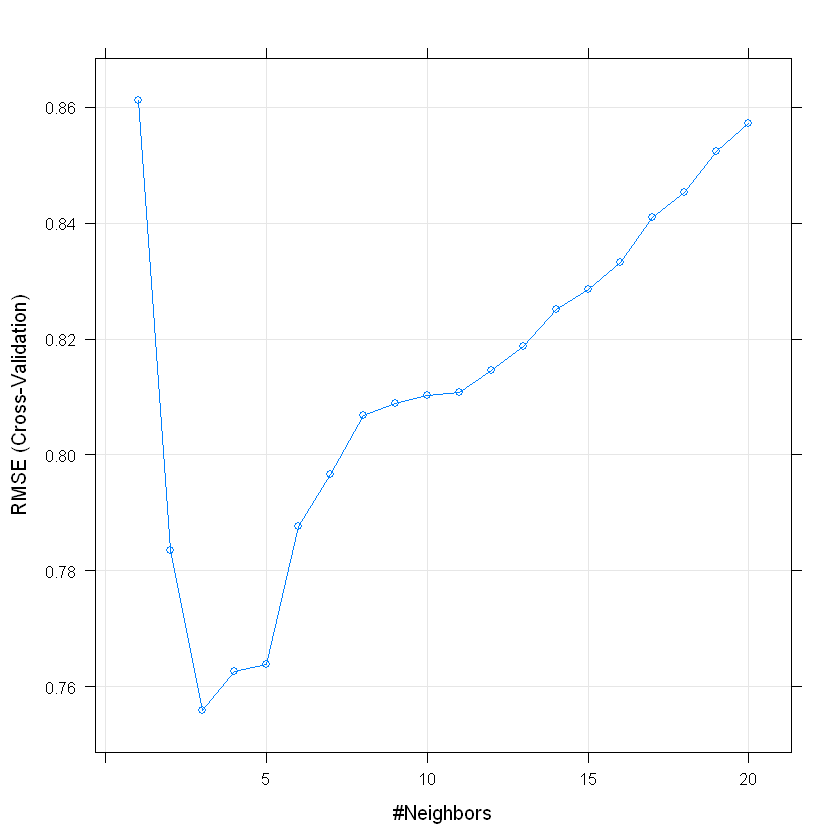

In [14]:
# KNN
# Center and scale data
beer.normGrav.subsample.knn = train(ABV~., data=beer.normGrav.subsample, method="knn", trControl = k10_cv, preProcess = c("center", "scale"), tuneGrid = expand.grid(k = 1:20))
print(beer.normGrav.subsample.knn)
plot(beer.normGrav.subsample.knn)

k-Nearest Neighbors 

1000 samples
   2 predictor

Pre-processing: centered (2), scaled (2) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 900, 900, 900, 900, 900, 901, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  0.1820093  0.9902587  0.1061884
   2  0.1652853  0.9918588  0.1007004
   3  0.1634795  0.9920638  0.0985809
   4  0.1755689  0.9911886  0.1046414
   5  0.1940950  0.9893417  0.1105279
   6  0.2083173  0.9877529  0.1136828
   7  0.2195153  0.9867765  0.1178992
   8  0.2334462  0.9850670  0.1239660
   9  0.2454648  0.9837696  0.1282368
  10  0.2559327  0.9823824  0.1333404
  11  0.2660633  0.9810534  0.1364151
  12  0.2734362  0.9801643  0.1411550
  13  0.2824554  0.9789881  0.1455957
  14  0.2932388  0.9771038  0.1502274
  15  0.3018628  0.9759559  0.1535028
  16  0.3111676  0.9745010  0.1562208
  17  0.3176266  0.9731716  0.1588829
  18  0.3258827  0.9723866  0.1633852
  19  0.3351990  0.9712590  0.1676331
  

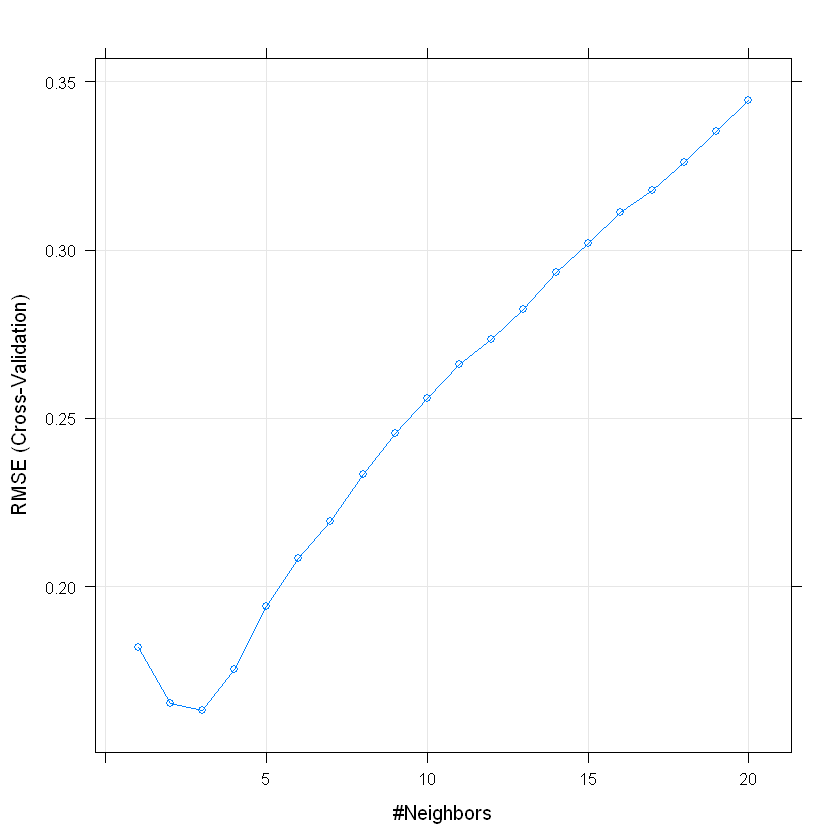

In [15]:
# Now try with the descriptors we ID'd, OG and FG
beer.normGrav.subsample.knn2 = train(ABV~OG+FG, data=beer.normGrav.subsample, method="knn", trControl = k10_cv, preProcess = c("center", "scale"), tuneGrid = expand.grid(k = 1:20))
print(beer.normGrav.subsample.knn2)
plot(beer.normGrav.subsample.knn2)

k-Nearest Neighbors 

1000 samples
   1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 899, 900, 901, 900, 900, 899, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  0.4245126  0.9439471  0.3264984
   2  0.4209366  0.9444917  0.3236463
   3  0.4199881  0.9445055  0.3213834
   4  0.4215362  0.9436761  0.3227888
   5  0.4262850  0.9425415  0.3240722
   6  0.4297562  0.9412520  0.3251826
   7  0.4320999  0.9407830  0.3261036
   8  0.4351792  0.9401009  0.3273428
   9  0.4425364  0.9380516  0.3301441
  10  0.4433230  0.9379597  0.3294128
  11  0.4436696  0.9380701  0.3292862
  12  0.4450027  0.9376090  0.3295314
  13  0.4516525  0.9359753  0.3305497
  14  0.4535120  0.9357246  0.3317260
  15  0.4540740  0.9355193  0.3312878
  16  0.4583110  0.9344839  0.3324704
  17  0.4588538  0.9343075  0.3326411
  18  0.4623783  0.9332254  0.3334463
  19  0.4620499  0.9333522  0.3338353
  

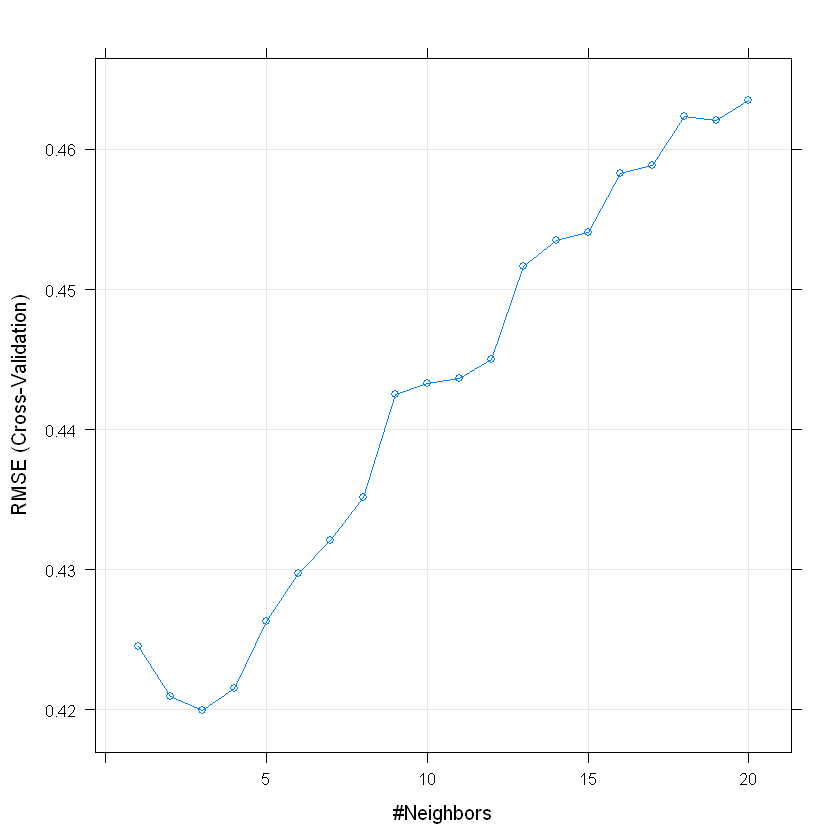

In [16]:
# Because FG is measured a lot later in the process than OG, let's just try to look at the original specific gravity of the wort, prior to boiling
beer.normGrav.subsample.knn1 = train(ABV~OG, data=beer.normGrav.subsample, method="knn", trControl = k10_cv, preProcess = c("center", "scale"), tuneGrid = expand.grid(k = 1:20))
print(beer.normGrav.subsample.knn1)
plot(beer.normGrav.subsample.knn1)
